# AUTOENCODER ANALYSIS

This notebook contains exploratory analysis of the images from **CREDO** dataset. We use Autoencoders to find and detect anomalies in the given dataset. 

#### Dataset
Dataset contains thousands of images of size **(60x60)** in **.png** format.



<hr>

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.utils import make_grid
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Data preparation

First step is to create a dataset, that will load images and feed them to the model. Since there are a lot of images here, we don't want to load them all at once - instead we use **batches**. 

In [2]:
class ImgDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(".png")]

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.image_files[index])
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.image_files)


Then we define some key properties like:
- **transform** function - converts and normalizes image
- **dataset** - creates dataset using class above

In [3]:
transform = v2.Compose([v2.ToImage(),
                        v2.ToDtype(torch.float32),
                        v2.Normalize(mean=[0.5], std=[0.5])
                        ])
dataset = ImgDataset( 
                     root_dir='../data/processed', 
                     transform=transform)

In [4]:
print(f'Max: {dataset[30].max()}\nMin: {dataset[30].min()}')

Max: 61.0
Min: -1.0


Last step is to divide the data into training & test sets

In [5]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size], 
                                     generator=torch.Generator().manual_seed(42))


In [6]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### Preprocessing summary statistics

In [7]:
# Calculate the number of images
num_images = len(dataset)

# Calculate the train and test sizes
train_size = len(train_data)
test_size = len(test_data)

# Calculate the image max and min values
image_max = dataset[0].max()
image_min = dataset[0].min()

# Get the image format and dimensions
image_format = '.png'
image_size = dataset[0].view(60, 60).numpy().shape
image_dimensions = dataset[0].shape

# Display the statistics
print(f"Number of Images: {num_images}")
print(f"Train Size: {train_size}")
print(f"Test Size: {test_size}")
print(f"Image Format: {image_format}")
print(f"Image Size: {image_size}")
print(f"Image Dimensions: {image_dimensions}")
print(f"Image Max Value: {image_max}")
print(f"Image Min Value: {image_min}")


Number of Images: 110000
Train Size: 99000
Test Size: 11000
Image Format: .png
Image Size: (60, 60)
Image Dimensions: torch.Size([1, 60, 60])
Image Max Value: 125.0
Image Min Value: -1.0


Let's visualize some of the data we're dealing with

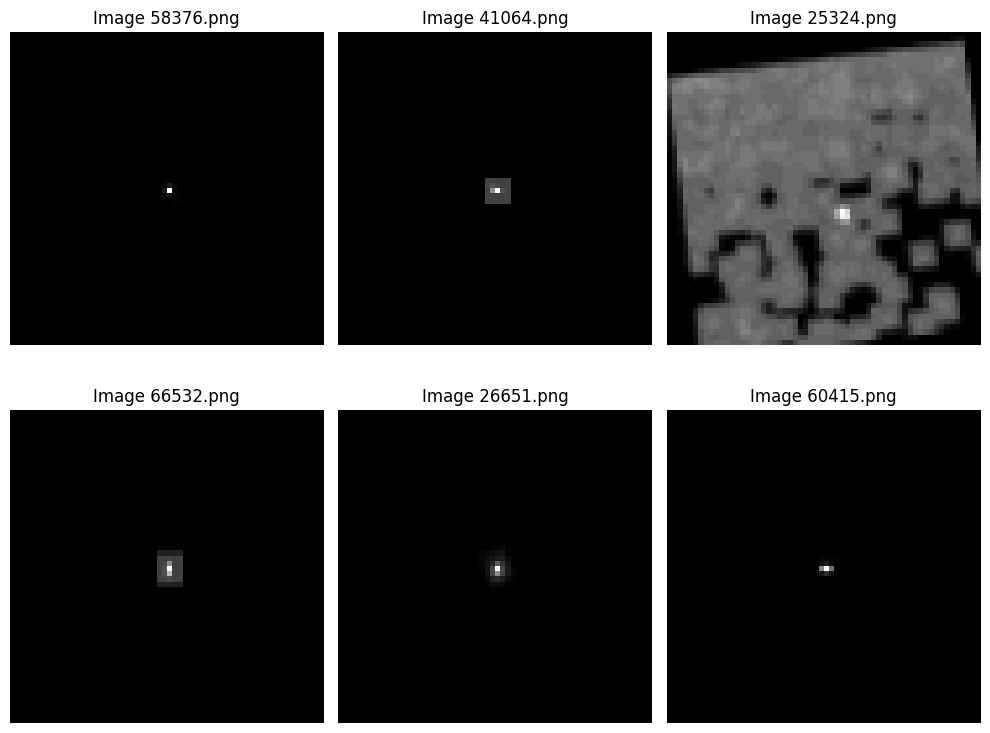

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    random_index = random.randint(0, len(train_loader.dataset))
    image = train_loader.dataset[random_index].view(60, 60).numpy()
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Image {random_index}.png')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [9]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


## Model with linear layers

Now it's time to create the model which we will train to detect anomalies.
Our sequential models consists of the following:
1. Encoder - reduces dimensionality
2. Decoder - expands dimensionality

#### Encoder architecture
- 5 linear layers (each one gradually reduces dimensionality until reaching size of 4)
- 4 LeakyReLU activation functions. The follow linear layers and introduce non-linearity 

#### Decoder architecture
- 5 linear layers (each one gradually expands dimensionality until reaching size of 4)
- 4 LeakyReLU activation functions. The follow linear layers and introduce non-linearity 
- 1 Sigmoid activation function (Sigmoid), because images are normalized to [0, 1]


In [ ]:
class Autoencoder(nn.Module):
    
    def __init__(self):

        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(60 * 60, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 256),
            nn.LeakyReLU(True), 
            nn.Linear(256, 128),
            nn.LeakyReLU(True),
            nn.Linear(128, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 32),
            nn.LeakyReLU(True),
            nn.Linear(32, 16)
        ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(True),
            nn.Linear(32, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 128),
            nn.LeakyReLU(True), 
            nn.Linear(128, 256),
            nn.LeakyReLU(True),
            nn.Linear(256, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 60 * 60),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
model_lin = Autoencoder()

## Model with Convolutional layers
As for the second model, we propose the same architecture as the first one, but instead of using linear layers, we swap them out with Convolutional ones.

Since we're using basically the same architecture, we will have a clear understanding of the differences as well as the similarities of both models.

It will also make the task of comparing them much easier and fair

In [ ]:
class AutoencoderConvolutional(nn.Module):

    def __init__(self) -> None:
        
        super(AutoencoderConvolutional, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2),  # N, 16, 30, 30
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # N, 32, 15, 15
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # N, 64, 8, 8
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),  # N, 128, 4, 4
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),  # N, 64, 8, 8
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),  # N, 32, 16, 16
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),  # N, 16, 32, 32
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2),  # N, 1, 64, 64
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
model_conv = AutoencoderConvolutional()

Below we define some training parameters:
- Number of epochs
- Criterion
- Learning rate
- Weight decay
- Optimizer

In [ ]:
EPOCHS = 15
CRITERION = nn.MSELoss()
LEARNING_RATE = 1e-3
# Optimizers
OPTIMIZER_LIN = optim.Adam(model_lin.parameters(), lr=LEARNING_RATE)
OPTIMIZER_CONV = optim.Adam(model_conv.parameters(), lr=LEARNING_RATE)


## Model Training

Now we train our model on the given data, with the use of parameters defined above

In [ ]:
output_linear = []
losses = []

for e in range(EPOCHS):
    for img in train_loader:
        img = img.reshape(-1, 60 * 60)
        recon = model_lin(img)
        loss = CRITERION(recon, img)

        OPTIMIZER_LIN.zero_grad()
        loss.backward()
        OPTIMIZER_LIN.step()
        
    losses.append(loss.item())  
    print(f'Epoch: {e + 1}, Loss: {loss.item():.4f}')
    output_linear.append((e, img, recon))

In [ ]:
n = 6  # Number of images you want to display
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(60, 60), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].detach().numpy().reshape(60, 60), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
# Calculate the reconstruction error for each image
reconstruction_error = np.mean((np.power((recon.detach().numpy() - img.detach().numpy()), 2)), axis=1)

In [ ]:
reconstruction_error_df = pd.DataFrame({'reconstruction_error': reconstruction_error,
                                        'true_class': [0] * len(reconstruction_error)})

In [ ]:
reconstruction_error_df

In [ ]:
plt.plot(range(1, EPOCHS + 1), losses[-1].detach().numpy(), marker='o')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
num_examples = 6
fig, axes = plt.subplots(num_examples, 2, figsize=(16, 6 * num_examples))

for i in range(num_examples):
    axes[i, 0].imshow(img[i].view(60, 60).numpy(),
                      cmap='gray', 
                      aspect=plt.gca().set_aspect('equal'))
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(recon[i].view(60, 60).detach().numpy(), 
                      cmap='gray', 
                      aspect=plt.gca().set_aspect('equal'))
    axes[i, 1].set_title('Reconstructed')

plt.show()

In [ ]:
encoder_weights = model_lin.encoder[0].weight.data

num_features_to_visualize = 16
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(num_features_to_visualize):
    ax = axes[i // 4, i % 4]
    feature = encoder_weights[i].view(60, 60).detach().numpy()
    ax.imshow(feature, cmap='gray')
    ax.set_title(f'Feature {i + 1}')

plt.show()

In [ ]:
# Calculate model accuracy
accuracy = sum(reconstruction_error_df['true_class'] == 0) / len(reconstruction_error_df)

In [ ]:
accuracy

In [ ]:
threshold = 0.00085

plt.plot(range(1, EPOCHS + 1), losses, marker='o')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model_lin.eval()
anomalies = []

for img in test_loader:
    img = img.reshape(-1, 60 * 60)
    recon = model_lin(img)
    loss = CRITERION(recon, img)

    if loss.item() > threshold:
        anomalies.append((img, recon, loss.item()))

len(anomalies)

In [ ]:
num_anomalies_to_visualize = min(len(anomalies), 3)
fig, axes = plt.subplots(3, 2, figsize=(14, 7 * num_anomalies_to_visualize))

for i in range(num_anomalies_to_visualize):
    axes[i, 0].imshow(img[i].view(60, 60).numpy(), cmap='gray')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(anomalies[0][0][i].view(60, 60).detach().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Reconstructed\nLoss: {anomalies[i][2]:.4f}')

plt.show()

<hr>

In [ ]:
autoencoder = AutoencoderConvolutional()
img = torch.randn(1, 1, 60, 60)
conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=1)
print(conv1(img).shape)
conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=1)
print(conv2(conv1(img)).shape)
conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1)
print(conv3(conv2(conv1(img))).shape)
conv4 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=1)
print(conv4(conv3(conv2(conv1(img)))).shape)
conv5 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=1)
print(conv5(conv4(conv3(conv2(conv1(img))))).shape)


In [ ]:
class AutoencoderConvolutional(nn.Module):
    def __init__(self) -> None:
        super(AutoencoderConvolutional, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 1, 16, 60, 60
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 1, 32, 30, 30
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 1, 64, 15, 15
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 1, 128, 8, 8
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=1),  # 1, 128, 8, 8
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1), # N, 128, 8, 8
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # N, 64, 16, 16
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),  # N, 32, 32, 32
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # N, 16, 64, 64
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # N, 1, 64, 64
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

model_conv = AutoencoderConvolutional()


In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv.to(device)

for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data[0].to(device)

        # Forward pass
        outputs = model_conv(inputs)
        loss = CRITERION(outputs, inputs)

        # Backward pass and optimization
        OPTIMIZER_CONV.zero_grad()
        loss.backward()
        OPTIMIZER_CONV.step()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=200, act_fn=nn.LeakyReLU()):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # (32, 32)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1), 
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (16, 16)
            act_fn,
            nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (8, 8)
            act_fn,
            nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(4*out_channels*8*8, latent_dim),
            act_fn
        )
    
    def forward(self, x):
        x = x.view(-1, 3, 60, 60)
        output = self.net(x)
        return output

In [ ]:
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=16, latent_dim=200, act_fn=nn.LeakyReLU()):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels*8*8),
        act_fn
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (8, 8)
        act_fn,
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (16, 16)
        act_fn,
        nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (32, 32)
        act_fn,
        nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 4*self.out_channels, 8, 8)
    output = self.conv(output)
    return output

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set, test_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  initializing network weights
    self.network.apply(init_weights)


    #  setting convnet to training mode
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #------------
      #  TRAINING
      #------------
      print('training...')
      for images in tqdm(train_loader):
        #  zeroing gradients
        self.optimizer.zero_grad()
        #  sending images to device
        images = images.to(device)
        #  reconstructing images
        output = self.network(images)
        #  computing loss
        loss = loss_function(output, images.view(-1, 3, 32, 32))
        #  calculating gradients
        loss.backward()
        #  optimizing weights
        self.optimizer.step()

        #--------------
        # LOGGING
        #--------------
        log_dict['training_loss_per_batch'].append(loss.item())

      #--------------
      # VALIDATION
      #--------------
      print('validating...')
      for val_images in tqdm(test_loader):
        with torch.no_grad():
          #  sending validation images to device
          val_images = val_images.to(device)
          #  reconstructing images
          output = self.network(val_images)
          #  computing validation loss
          val_loss = loss_function(output, val_images.view(-1, 3, 32, 32))

        #--------------
        # LOGGING
        #--------------
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      #--------------
      # VISUALISATION
      #--------------
      print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

      for test_images in test_loader:
        #  sending test images to device
        test_images = test_images.to(device)
        with torch.no_grad():
          #  reconstructing test images
          reconstructed_imgs = self.network(test_images)
        #  sending reconstructed and images to cpu to allow for visualization
        reconstructed_imgs = reconstructed_imgs.cpu()
        test_images = test_images.cpu()

        #  visualisation
        imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], 
                          dim=1).flatten(0,1)
        grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
        grid = grid.permute(1, 2, 0)
        plt.figure(dpi=170)
        plt.title('Original/Reconstructed')
        plt.imshow(grid)
        log_dict['visualizations'].append(grid)
        plt.axis('off')
        plt.show()
      
    return log_dict

  def autoencode(self, x):
    return self.network(x)

  def encode(self, x):
    encoder = self.network.encoder
    return encoder(x)
  
  def decode(self, x):
    decoder = self.network.decoder
    return decoder(x)

In [ ]:
#  training model
model = ConvolutionalAutoencoder(Autoencoder(Encoder(), Decoder()))

log_dict = model.train(nn.MSELoss(), epochs=10, batch_size=64, 
                       training_set=dataset, validation_set=dataset,
                       test_set=test_data)